# Weak lensing weights
## Weak lensing weights to compute the $\Delta\Sigma$ profile

The excess surface mass density profile computed from the data is computed from a weighted average
$$
     \widehat{\Delta\Sigma}_+(R) = \frac{1}{\sum\limits_{l,s = 1} w_{l,s}}
     \sum\limits_{l,s= 1}w_{l,s}\widehat{\Sigma_{{\rm crit}}}(z_s, z_l)\epsilon_+^{l,s}.
$$

where the sum runs over all lens-background source pairs, $\epsilon_+^{l,s}$ is the tangential ellipticity, $\Sigma_{\rm crit}(z_s, z_l)$ is the critical surface density, and where the weights

$$
    w_{l,s} = \frac{\left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^2}{\sigma^2_{\rm shapenoise} + \sigma^2_{\rm shape\ error}}.
$$
Where $p(z)$ is the photometric redshift ditribution. These weights correspond to the maximum likelihood estimator of $\Delta\Sigma$ (e.g., Shirasaki & Takada 2018).

Identifying background galaxies can be made by considering the individual probability to be in the background of the cluster i.e. 
$$
P(z > z_l) = \int_{z_l}^{+\infty} dz\ p(z) 
$$
to be higher than a given threshold.

In this notebook, we show the `clmm` functionalities developed to compute:
- those weights under a variety of configuration (true redhsifts or photoz, shape noise or not, ideal galaxy shapes or not).
- the background probability $P(z > z_l)$ for each galaxy

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy
import copy

import clmm
from clmm import Cosmology
from clmm import GalaxyCluster
from clmm.dataops import compute_galaxy_weights, compute_background_probability
from clmm.support import mock_data as mock
from clmm.theory import compute_critical_surface_density_eff

clmm.__version__

'1.12.0'

In [2]:
np.random.seed(11)

In [3]:
cosmo = Cosmology(H0=71.0, Omega_dm0=0.265 - 0.0448, Omega_b0=0.0448, Omega_k0=0.0)

In [4]:
cluster_z = 0.4
cluster_m = 1.0e14
cluster_c = 4
cluster_ra = 0.0
cluster_dec = 0.0

In [5]:
noisy_data_z = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    cluster_c,
    cosmo,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
    delta_so=200,
    massdef="critical",
    halo_profile_model="nfw",
    zsrc="chang13",
    zsrc_min=0.15,
    zsrc_max=3.0,
    photoz_sigma_unscaled=0.05,
    shapenoise=0.05,
    mean_e_err=0.1,
    field_size=10.0,
    ngals=3000,
)
z_gal = noisy_data_z["ztrue"]
# add redshift dependency on shape measurement error
noisy_data_z["e_err"] = noisy_data_z["e_err"] * (1 + 0.4 * noisy_data_z["ztrue"])
cluster = GalaxyCluster("mock_cluster", cluster_ra, cluster_dec, cluster_z, noisy_data_z)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/theory/parent_class.py:768: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Shear = 0 for those galaxies.
/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/theory/parent_class.py:852: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Convergence = 0 for those galaxies.


## Compute the WL weights

### redshift point estimate + no shape error

$$
w_{\rm ls} = \Sigma_{\rm crit}(z_l, z_s)^{-2}
$$

#### Using the functional interface

First, we need to compute $\Sigma_{\rm crit}$. Here, we use the true source redshifts stored in `z_gal`

In [6]:
sigma_c = cosmo.eval_sigma_crit(cluster_z, z_gal)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [7]:
w_ls_true = compute_galaxy_weights(
    sigma_c=sigma_c,
    is_deltasigma=True,
    use_shape_noise=False,
)

#### As a method of the `GalaxyCluster` object
As a method of the `GalaxyCluster` object, `compute_galaxy_weights` uses the content of the `z` column of the object's `galcat` table as the source redshift point estimates. Given that mock data was generated with a photoz error, this point estimate is different from the true redshift used in the cell above.

In [8]:
w_ls_point = cluster.compute_galaxy_weights(
    use_pdz=False, weight_name="w_ls_point", cosmo=cosmo, is_deltasigma=True, add=True
)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


### photoz + no shape errors

When considering the photo-z distribution, we can compute the weight based on an effective critical surface density:

$$
w_{\rm ls} = \Sigma_{\rm crit}^{\rm eff}(z_l)^{-2},
$$

where

$$
\Sigma_{\rm crit}^{\rm eff}(z_l) = \left(\int_{z_l}^{+\infty}\Sigma_{\rm crit}(z_l, z)^{-1}p(z) dz\right)^{-1}.
$$

#### Using the functional interface

First, we need to compute $\Sigma_{\rm crit}^{\rm eff}$. Here, we use the true source redshifts stored in `z_gal`

In [9]:
sigma_c_eff = compute_critical_surface_density_eff(
    cosmo=cosmo,
    z_cluster=cluster_z,
    pzbins=noisy_data_z.pzpdf_info["zbins"],
    pzpdf=noisy_data_z["pzpdf"],
)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/redshift/tools.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


In [10]:
w_ls_photoz = compute_galaxy_weights(
    sigma_c=sigma_c_eff,
    is_deltasigma=True,
    use_shape_noise=False,
)

#### As a method of the `GalaxyCluster` object

When used as a method of the `GalaxyCluster` object, with `use_pdz=True`, `compute_galaxy_weights` uses the content of the `pzpdf` and `pzbins` columns of the `galcat` table. It will return an error if those do not exist.

In [11]:
w_ls_photoz = cluster.compute_galaxy_weights(
    use_pdz=True, weight_name="w_ls_photoz", cosmo=cosmo, is_deltasigma=True, add=True
)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/cosmology/parent_class.py:110: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/redshift/tools.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


### redshift point estimate + shape error

$$
w_{\rm ls} = \frac{\Sigma_{\rm crit}(z_l, z_s)^{-2}}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [12]:
w_ls_shape = cluster.compute_galaxy_weights(
    use_pdz=False,
    use_shape_noise=True,
    shape_component1="e1",
    shape_component2="e2",
    use_shape_error=True,
    shape_component1_err="e_err",
    shape_component2_err="e_err",
    weight_name="w_ls_shape",
    cosmo=cosmo,
    is_deltasigma=True,
    add=True,
)

### photoz + shape error

$$
w_{\rm ls} = \frac{\Sigma_{\rm crit}^{\rm eff}(z_l, z)^{-2}}{\sigma_{\rm shapenoise}^2 + \sigma^2_{\rm shape\ error}}
$$

In [13]:
w_ls_photoz_shape = cluster.compute_galaxy_weights(
    use_pdz=True,
    use_shape_noise=True,
    shape_component1="e1",
    shape_component2="e2",
    use_shape_error=True,
    shape_component1_err="e_err",
    shape_component2_err="e_err",
    weight_name="w_ls_photoz_shape",
    cosmo=cosmo,
    is_deltasigma=True,
    add=True,
)

With `add=True`, the weights have been added as new columns in the `cl.galcat` Table. A new `sigma_c` column is also automatically added.

In [14]:
cluster.galcat.colnames

['ra',
 'dec',
 'e1',
 'e2',
 'e_err',
 'z',
 'ztrue',
 'pzpdf',
 'id',
 'sigma_c',
 'w_ls_point',
 'sigma_c_eff',
 'w_ls_photoz',
 'w_ls_shape',
 'w_ls_photoz_shape']

### $\Sigma_{\rm crit}$ metadata

As seen above, the weights are computed either using the standard definition of $\Sigma_{\rm crit}^{\rm std}$, using point estimate redshift, or the effective definition based on the inverse $\Sigma_c^{\rm eff}$ averaged over the redshift PDF $p(z)$:

$$ 
\Sigma_{\rm crit}^{\rm std}\equiv\Sigma_{\rm crit}(z_l, z_s) \;\;{\rm and}\;\; \Sigma_{\rm crit}^{\rm eff}\equiv\left( \int \Sigma_{\rm crit}(z_l, z)^{-1} p(z) dz\right)^{-1}
$$

To keep track of what definition of $\Sigma_{\rm crit}$ was used, `standard` or `effective` the user may look into the `galcat` metadata 

In [15]:
print(
    "For cluster w_ls_point column        :",
    cluster.galcat.meta["w_ls_point_sigmac_type"],
)
print(
    "For cluster w_ls_photoz column       :",
    cluster.galcat.meta["w_ls_photoz_sigmac_type"],
)
print(
    "For cluster w_ls_shape column        :",
    cluster.galcat.meta["w_ls_shape_sigmac_type"],
)
print(
    "For cluster w_ls_photoz_shape column :",
    cluster.galcat.meta["w_ls_photoz_shape_sigmac_type"],
)

For cluster w_ls_point column        : standard
For cluster w_ls_photoz column       : effective
For cluster w_ls_shape column        : standard
For cluster w_ls_photoz_shape column : effective


### Vizualizing the results

The figure below shows the normalized weight per galaxy $\widehat{w}_{ls} = \frac{w_{ls}}{\sum _{s = 1}^N w_{ls}}$.

Text(0.5, 0, 'true redshift')

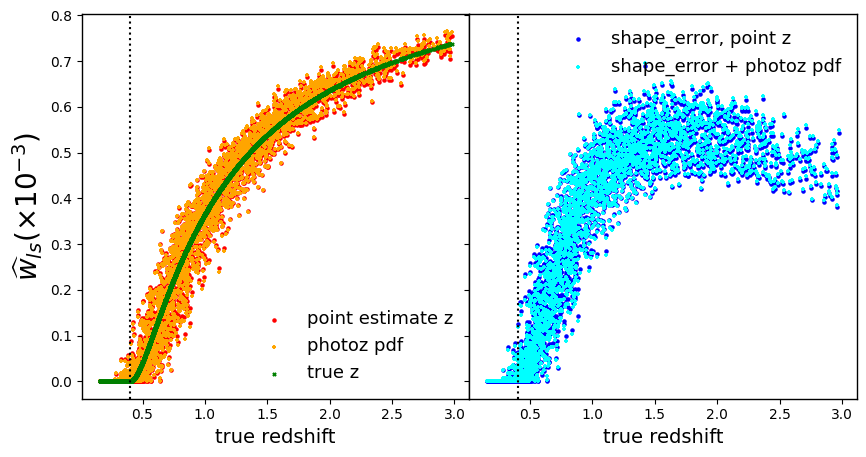

In [16]:
plt.rcParams["axes.linewidth"] = 1
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)
ax[0].tick_params(axis="both", which="major", labelsize=10)
ax[1].tick_params(axis="both", which="major", labelsize=10)

ax[0].axvline(cluster_z, color="black", linestyle=":")
ax[1].axvline(cluster_z, color="black", linestyle=":")

ax[0].scatter(
    z_gal,
    1e3 * cluster.galcat["w_ls_point"] / cluster.galcat["w_ls_point"].sum(),
    c="r",
    label="point estimate z",
    s=5,
)
ax[0].scatter(
    z_gal,
    1e3 * cluster.galcat["w_ls_photoz"] / cluster.galcat["w_ls_photoz"].sum(),
    c="orange",
    label="photoz pdf",
    marker="+",
    s=5,
)
ax[0].scatter(z_gal, 1e3 * w_ls_true / w_ls_true.sum(), c="g", label="true z", marker="x", s=5)
ax[1].scatter(
    z_gal,
    1e3 * cluster.galcat["w_ls_shape"] / cluster.galcat["w_ls_shape"].sum(),
    c="blue",
    label=r"shape_error, point z",
    s=5,
)
ax[1].scatter(
    z_gal,
    1e3 * cluster.galcat["w_ls_photoz_shape"] / cluster.galcat["w_ls_photoz_shape"].sum(),
    c="cyan",
    label="shape_error + photoz pdf",
    s=5,
    marker="+",
)
ax[0].legend(frameon=False, fontsize=13)
ax[1].legend(frameon=False, fontsize=13)
ax[0].set_ylabel(r"$\widehat{w}_{ls} (\times 10^{-3})$", fontsize=20)
ax[0].set_xlabel("true redshift", fontsize=14)
ax[1].set_xlabel("true redshift", fontsize=14)

- The galaxy weights increase with the true galaxy redshift (left panel, red dots), i.e. weights take account that galaxies far from the cluster are more sheared than closer ones.
- Using true redshift (left panel, green dots), weights for foreground galaxies are 0.
- Adding photoz, either point estimate or including p(z) (left panel, red and orange dots):
   - weights are scattered around the true redshift weigthts (when photoz's are not biased)
   - some foreground galaxies (with true redshift < $z_{\rm cluster}$) have non-zero weights
   - here the point estimate and p(z) results are very close because `mock_data` generates photoz a gaussian p(z) with the point estimate at the mean. Reality will be more complex and the orange and red points may differ more.
- Adding shape error with redshift dependency $\sigma(z) = \sigma_0(1 + \alpha z)$ (right panel, blus dots), high redshift galaxies with measured shapes have smaller weights than considering true shapes (comparing to left panel, red dots).
- when combining photoz + shape error, both effects can be seen on galaxy weights (right panel, cyan dots).

### Background probability

The probability for a galaxy with photometric redshift of being in the background of the cluster is given by
$$
P(z > z_l) = \int_{z_l}^{+\infty} dz\ p(z) 
$$

In [17]:
# Generate new GC object with smaller photoz dispersion for comparison with cl0.
noisy_data_z_2 = mock.generate_galaxy_catalog(
    1e14,
    cluster_z,
    4,
    cosmo,
    delta_so=200,
    massdef="critical",
    halo_profile_model="nfw",
    zsrc="chang13",
    zsrc_min=0.1,
    zsrc_max=3.0,
    photoz_sigma_unscaled=0.02,
    shapenoise=0.05,
    mean_e_err=0.1,
    field_size=10.0,
    ngals=3000,
)
cluster_new = clmm.GalaxyCluster("mock_cluster", 0, 0, cluster_z, noisy_data_z_2)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/theory/parent_class.py:768: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Shear = 0 for those galaxies.
/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/theory/parent_class.py:852: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Convergence = 0 for those galaxies.


In [18]:
p_background_true = compute_background_probability(cluster_z, z_gal)  # based on cl0 generation

In [19]:
p_background_photoz_1 = cluster.compute_background_probability(
    use_pdz=True, p_background_name="p_background_photoz_1", add=True
)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/redshift/tools.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


In [20]:
p_background_photoz_2 = cluster_new.compute_background_probability(
    use_pdz=True, p_background_name="p_background_photoz_2", add=True
)

/home/tomomis/anaconda3/envs/clmm-env/lib/python3.9/site-packages/clmm-1.12.0-py3.9.egg/clmm/redshift/tools.py:58: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0


Text(0.5, 0, 'obs. source redshift')

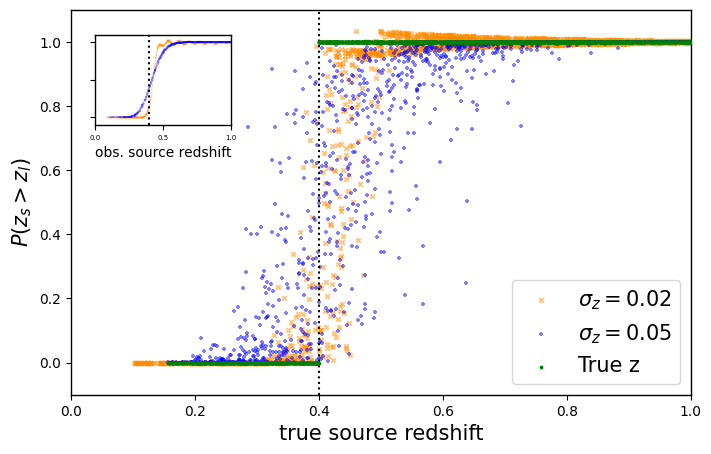

In [21]:
# plt.rcParams['axes.linewidth'] = 1
fig = plt.figure(figsize=(8, 5))

plt.tick_params(axis="both", which="major", labelsize=10)
plt.scatter(
    cluster_new.galcat["ztrue"],
    p_background_photoz_2,
    c="darkorange",
    label=r"$\sigma_z = 0.02$",
    marker="x",
    s=10,
    alpha=0.5,
)
plt.scatter(
    cluster.galcat["ztrue"],
    p_background_photoz_1,
    c="blue",
    label=r"$\sigma_z = 0.05$",
    marker="+",
    s=10,
    alpha=0.5,
)
plt.scatter(z_gal, p_background_true, c="green", s=3, zorder=110, label="True z")

plt.vlines(cluster_z, -0.1, 1.1, color="k", linestyle=":")
plt.xlim([0.0, 1])
plt.ylim([-0.1, 1.1])

plt.xlabel("true source redshift", fontsize=15)
plt.ylabel(r"$P(z_s > z_l)$", fontsize=15)
plt.legend(frameon=True, fontsize=15, loc=4)


ax2 = fig.add_axes([0.155, 0.65, 0.17, 0.18])
ax2.scatter(
    cluster_new.galcat["z"],
    p_background_photoz_2,
    c="darkorange",
    label=r"$\sigma_z = 0.02$",
    marker="x",
    s=1,
    alpha=0.5,
    lw=0.1,
)
ax2.scatter(
    cluster.galcat["z"],
    p_background_photoz_1,
    c="blue",
    label=r"$\sigma_z = 0.05$",
    marker="+",
    s=1,
    alpha=0.5,
    lw=0.1,
)
for item in (
    ax2.title,
    ax2.xaxis.label,
    ax2.yaxis.label,
    *ax2.get_xticklabels(),
    *ax2.get_yticklabels(),
):
    item.set_fontsize(5)
ax2.set_yticklabels([])
ax2.vlines(cluster_z, -0.1, 1.1, color="k", linestyle=":")
ax2.set_xlim([0.0, 1])
ax2.set_ylim([-0.1, 1.1])
ax2.set_xlabel("obs. source redshift", fontsize=10)

The figure above shows the background probability $P(z > z_l)$ for each galaxy.
- When using true redshift (green), the background probability is a Heavyside function centered on $z_s$, i.e. $p(z) = \delta^D(z-z_s)$.
- When using photometric redshift (blue and orange dots), galaxies on the foreground of the cluster have non-zero probability to be in the background. Idem, for close galaxies in the background, the probability in being in the foreground is non-zero.
- These weights represent the fraction of the galaxy PDF that is located behind the cluster and is mapped to the observed redshift as it can be seen on the top left panel. The scatter in the main panel comes from the scatter between true and observed redshifts.